In [101]:
from imports import *


# machine learning
from scipy import stats
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample
from sklearn.base import clone
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, r2_score
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

pd.options.display.max_columns = 100

### Problem Statement and Research Question

Economic growth is traditionally understood to be driven by three fundamental factors: human capital, geography, and institutions. These drivers shape the trajectory of nations and are frequently studied in growth literature. Less explored, however, are the reasons why these three factors vary across countries. We hypothesize that people’s beliefs play a key role in economic development. Specifically, we argue that beliefs about trust, equality, work ethic, and religion influence the likelihood of countries to adopt democratic institutions. Value formation, after all, likely shapes citizens’ willingness to accept democracy. We expect to find that the aforementioned values are strongest in countries with democratic traditions and weakest in countries with autocratic traditions.

As such, our main research question is:

“What is the relationship between the moral values of a country — regarding trust, work ethic, religion, and equality — and the adoption of democratic institutions? What is the relative importance of each of these beliefs to constructing a working democracy?”


We use the World Values Survey (WVS), a dataset which provides survey data on peoples' beliefs, attitudes, and values across a large number of countries from 1995 to 2024, to start answering this question. We use this data to quantify the values of each country along the axes of trust, work ethic, religion, and equality over time. With this panel dataset, we then have the ability to explore the association between a country's values and their democracy index score (a score published by The Economist detailing how democratic a country is). We engage in this analysis below:

### Exploring and Visualizing Data

Things to include in the EDA:

1. Summary table (from milestone 3 python file). Talk a little too about the data cleaning we did and how we dealt with imbalanced data from countries (our imputation from milestone 2).
2. Histograms for each variable (from MS3 python file). Use mostly same description we used in our MS3 pdf to describe this with a few key differences: When talking about the leftward skew of religion over time, speak to how this might indicate that using wave fixed effects would be useful (which we will try in our analysis). For the GDP right skew part, talk about how it likely warrants a log transformation of GDP
3. Violin plots (from MS3 python file) and scatterplots (from MS3 python file): Mention how GDP very much has a log relationship here with democracy and it likely should be transformed as already mentioned. Other relationships between democracy index and our values appear generally linear, but we may explore transformation if we use a linear regression depending on how our baseline performs. Take points #2 and #3 from our violin plot discussion from MS3 pdf. Ignore point 1 since it may contradict what we do in the analysis.
4. Correlation matrix/heatmap (from MS3 python file): Talk about significant correlations between our predictors and how that might indicate a potential issue of multicollinearity (though not severe since |r| < 0.7 for the predictors we care about). Can lift the two points from the MS3 pdf for this section here as well.
5. Quick discussion of confounders: From our MS3 pdf "Finally, we will discuss potential confounders in our dataset. First, we have already controlled for GDP per capita and HDI, which are clear confounding variables. Other unobserved confounding variables include other historical and institutional factors, like whether or not a country has had colonial history or what the educational system’s characteristics are, even beyond HDI. We can try to operationalize the fact that we have panel data and deploy country and wave fixed effects to control for these unobserved confounders to figure out the true effect of the moral values on democracy."

As you work through it, try to find every way to connect our EDA to the analysis done down below (especially the fact that we chose a multiple linear regression and lasso as our baseline -- I did a fair amount of justification in the baseline section as well).

### Baseline Model and Results Interpretation

Based on our EDA, we believe that beginning with a multiple OLS regression and a LASSO regression as our baseline models is optimal. This is for a few reasons:

1. The relationships between our predictors and our response variable are reasonably linear (with the exception of GDP per capita which we will log transform). This means that a linear regression and its ensuing inference is valid.
2. An OLS linear regression and a LASSO regression are both simple, interpretable ways of understanding the associations between our values and the democracy index and also provide separate, easily interpretable forms of feature selection.
3. The OLS linear regression gives us the chance to perform statistical inference which is useful as we are trying to understand what values are closely associated with democracy across different countries.
4. The LASSO regression gives us another way to check on the features selected by our OLS regression while still preserving interpretability. 

In [102]:
df = pd.read_csv("cleaned_data/cleaned_wvs_data.csv")
df["log_gdp_per_capita"] = np.log(df["gdp_per_capita"])
df['equality_squared'] = df['equality']**2

In [103]:
df

,Country,Year,democracy_score,work_ethic,trust,equality,religion,country,gdp_per_capita,gdp_per_capita_std,gender_beat_wife,gender_business_exec,gender_job_rights,gender_political_leaders,gender_rights,hdi,religion_against_science,religion_attendance,religion_child,religion_confidence,religion_god,religion_god_importance,religion_identification,religion_only_religion,religion_pray,religion_right,tolerance_chairty_confidence,tolerance_charitable_org,tolerance_human_rights,tolerance_immigrant_work,tolerance_immigrants,tolerance_other_race,trust_first_meet,trust_most_people,trust_neighborhood,trust_other_national,trust_other_religion,trust_personally,work_child,work_importance,work_membership_pro_org,work_success,wave,log_gdp_per_capita,equality_squared
0,Argentina,2017,6.96,2.308943,2.496937,3.349680,2.805873,ARG,14613.035649,-0.002063,4.713936,3.605759,3.879697,3.488592,4.287758,0.853,3.067606,2.024237,1.197550,2.760491,4.666443,3.575449,4.222373,1.703456,2.679850,2.161279,3.014905,0.318971,2.464931,1.415137,4.793826,4.862961,1.895876,1.016820,3.336227,2.635871,2.728511,3.368316,2.823198,4.181511,0.204718,2.026343,3.0,9.589669,11.220353
1,Argentina,2013,6.84,2.056866,2.421878,3.357302,2.710240,ARG,13080.254732,-0.076785,4.744030,3.402337,3.827324,3.145191,4.248363,0.846,3.072915,2.041670,1.161009,2.559173,4.669794,3.607358,4.166942,1.413569,2.592646,1.817325,2.797419,0.529656,2.441110,1.983986,4.860343,4.950563,1.765118,0.992374,3.154370,2.579455,2.605160,3.434793,2.032350,4.032228,0.334831,1.828054,2.0,9.478859,11.271477
2,Argentina,2017,6.96,2.308943,2.496937,3.349680,2.805873,ARG,14613.035649,-0.002063,4.713936,3.605759,3.879697,3.488592,4.287758,0.853,3.067606,2.024237,1.197550,2.760491,4.666443,3.575449,4.222373,1.703456,2.679850,2.161279,3.014905,0.318971,2.464931,1.415137,4.793826,4.862961,1.895876,1.016820,3.336227,2.635871,2.728511,3.368316,2.823198,4.181511,0.204718,2.026343,3.0,9.589669,11.220353
3,Armenia,2021,5.49,2.536477,1.888417,2.711727,3.447211,ARM,4972.783204,-0.472020,4.820998,2.601450,2.059424,2.311143,4.272454,0.774,3.561399,1.892354,1.671786,3.462924,4.733399,4.519103,4.525404,3.916994,3.426459,2.762293,2.510905,0.447444,1.990692,1.038217,4.176748,3.599520,1.424604,0.425027,2.997472,1.769796,1.383922,3.329680,3.556984,4.468816,0.435577,1.684531,3.0,8.511735,7.353462
4,Armenia,2021,5.49,2.536477,1.888417,2.711727,3.447211,ARM,4972.783204,-0.472020,4.820998,2.601450,2.059424,2.311143,4.272454,0.774,3.561399,1.892354,1.671786,3.462924,4.733399,4.519103,4.525404,3.916994,3.426459,2.762293,2.510905,0.447444,1.990692,1.038217,4.176748,3.599520,1.424604,0.425027,2.997472,1.769796,1.383922,3.329680,3.556984,4.468816,0.435577,1.684531,3.0,8.511735,7.353462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,Zambia,2007,5.25,2.786944,1.839630,2.635808,3.764925,ZMB,1133.436158,-0.659186,3.133333,2.537778,2.955000,2.428889,3.865000,0.495,2.481481,3.773810,3.046667,4.017778,NaN,4.544815,4.725000,NaN,NaN,NaN,2.630000,0.876667,2.548889,0.868333,3.623333,3.526667,1.256667,0.560000,2.766667,1.567778,2.100000,2.786667,4.056667,4.516667,1.083333,1.491111,1.0,7.033009,6.947484
263,Zambia,2007,5.25,2.786944,1.839630,2.635808,3.764925,ZMB,1133.436158,-0.659186,3.133333,2.537778,2.955000,2.428889,3.865000,0.495,2.481481,3.773810,3.046667,4.017778,NaN,4.544815,4.725000,NaN,NaN,NaN,2.630000,0.876667,2.548889,0.868333,3.623333,3.526667,1.256667,0.560000,2.766667,1.567778,2.100000,2.786667,4.056667,4.516667,1.083333,1.491111,1.0,7.033009,6.947484
264,Zimbabwe,2020,3.16,2.501886,1.972794,3.001284,3.787893,ZWE,1372.696674,-0.647522,4.499314,3.068587,2.572016,2.578875,3.837860,0.554,2.498857,3.952381,2.740741,3.382716,4.991770,4.903978,4.903292,2.319616,4.458554,3.727023,3.526749,0.820988,1.842250,0.777778,4.748971,4.740741,1.458162,0.106996,2.932785,1.947874,2.495199,2.895748,3.716049,4.775034,0.6851

Now, let's fit our models. 

1) We train two models --- one a standard OLS linear model, and the second a linear regression with LASSO (L1) regularization. The OLS model will include all regressors of interest, and will be used as a performance baseline and to conduct statistical inference. The LASSO model will select only the important features, as the L1 penalty pushes less important coefficients to zero. Note: for our project, it does not make sense to perform dimensionality reduction via PCA on all the numerical variables. This is because PCA loses the interpretability that we are interested in, because it would collapse work_ethic, trust, equality, and religion into its principal components, which of course prevents us from determining which of these aspects are the most important. Moreover, we only have a few components to begin with, so dimensionality reduction is practicaly trivial.

2) We deal with the fact that the GDP Per Capita variable is on a much larger scale than the four WVS indices in two different ways. For the LASSO model, we use StandardScalar to standardize all variables. This improves model performance and also ensures that regularization accurately selects features. This decision is based on our EDA from milestone 3. For the OLS model, though, performance is scale-invariant, which means that it will not improve the R^2 if we use a StandardScalar. Instead, the model will simply lose interpretability, because now regression coefficients aren't interpreted in absolute units, but rather in standard deviations, which is slightly more opaque. For the OLS model, we thus log transform GDP Per Capita, which puts it on a similar scale as the rest of the variables. The log transformation also makes its coefficient more intuitive to interpret, because we typically think of income in percent changes rather than in absolutes.

3) Hyperparameter Tuning for LASSO model. Used 10-fold cross-validation with grid search. Tuned regularization strength (20 values log-spaced from 10^-2 to 10^2 which should very likely include our optimal regularization parameter). Cross-validation prevents overfitting, because it holds out validation data to prevent leakage. Grid search finds optimal complexity. Log-spaced regularization values test different strengths of L1 penalty. Under the best LASSO model, we can then see which features are most important (as these are the features with the highest coefficients/non-zero coefficients)

In [104]:
predictors = ["work_ethic", "trust", "equality", "religion", "log_gdp_per_capita", "hdi"]

X = df[predictors]
y = df["democracy_score"]

In [105]:
"""
Train OLS model
"""
# set up ols pipeline
ols_pipeline = Pipeline(steps=[
   ('regressor', LinearRegression())
])

# train OLS model and get cv results for our own understanding
ols_cv = cross_validate(
    ols_pipeline,
    X, y,
    cv=10,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

# get mean validation mse and std of mses
mean_mse = -ols_cv['test_score'].mean()
std_mse = ols_cv['test_score'].std()

print(f"OLS Cross-validation MSE: {mean_mse:.3f} (+/- {std_mse:.3f})")

ols_pipeline.fit(X, y)


OLS Cross-validation MSE: 2.482 (+/- 1.579)


Pipeline(steps=[('regressor', LinearRegression())])

In [106]:
"""
Train LASSO Model
"""

seed = 109

# set up lasso pipeline
lasso_pipeline = Pipeline(steps=[
   ('scaler', StandardScaler()),
   ('regressor', Lasso(random_state = seed, max_iter=10000))
])

# define lasso parameter grid
lasso_param_grid = {
    'regressor__alpha': np.logspace(-2, 2, 20)
}

# set up grid search
lasso_cv = GridSearchCV(
    lasso_pipeline,
    lasso_param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

lasso_cv.fit(X, y)

print("LASSO Best Parameters:", lasso_cv.best_params_)
print("LASSO Best Mean Squared Error:", -lasso_cv.best_score_)

LASSO Best Parameters: {'regressor__alpha': np.float64(0.06951927961775606)}
LASSO Best Mean Squared Error: 2.3831093671610395


Here is a graph illustrating our MSEs for our regularization terms which shows why we chose the alpha value that we did.

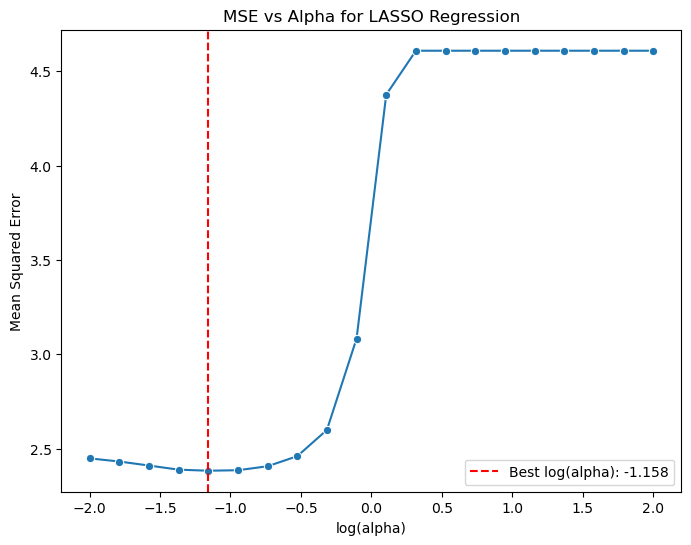

In [107]:
# get alphas and MSE scores from LASSO grid search results
alphas = lasso_cv.cv_results_['param_regressor__alpha'].data.astype(float)
mse_scores = -lasso_cv.cv_results_['mean_test_score']  # negative because we used neg_mean_squared_error
best_alpha = lasso_cv.best_params_['regressor__alpha']

# create plot
plt.figure(figsize=(8, 6))
sns.lineplot(x=np.log10(alphas), y=mse_scores, marker = 'o', errorbar=None)
plt.axvline(x=np.log10(best_alpha), color='r', linestyle='--', label=f'Best log(alpha): {np.log10(best_alpha):.3f}')
plt.xlabel('log(alpha)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha for LASSO Regression')
plt.legend()
plt.show()

Now, let's begin the analysis and model evaluation. First, here are the coeffficient values for both models.

In [108]:
# get best models / pipelines
best_model_ols = ols_pipeline.named_steps['regressor']
best_pipeline_ols = ols_pipeline
best_model_lasso = lasso_cv.best_estimator_.named_steps['regressor']
best_pipeline_lasso = lasso_cv.best_estimator_

# get coefficients from best models
ols_intercept = best_model_ols.intercept_
ols_coef = best_model_ols.coef_
ols_coef_full = np.concatenate(([ols_intercept], ols_coef))

lasso_intercept = best_model_lasso.intercept_
lasso_coef = best_model_lasso.coef_
lasso_coef_full = np.concatenate(([lasso_intercept], lasso_coef))

# create results dataframes
ols_results = pd.DataFrame({
    'Feature': ['Intercept'] + list(predictors),
    'Coefficient': ols_coef_full
})

lasso_results = pd.DataFrame({
    'Feature': ['Intercept'] + list(predictors),
    'Coefficient': lasso_coef_full
})

# rename features
feature_map = {
    'Intercept': "Intercept",
    'work_ethic': 'Work Ethic',
    'trust': 'Trust',
    'equality': 'Equality',
    'religion': 'Religion',
    'log_gdp_per_capita': 'Log GDP Per Capita',
    'hdi': 'Human Development Index',
}

ols_results['Feature'] = ols_results['Feature'].map(feature_map)
lasso_results['Feature'] = lasso_results['Feature'].map(feature_map)

ols_results_sorted = ols_results.sort_values(by='Coefficient', key=abs, ascending=False)
lasso_results_sorted = lasso_results.sort_values(by='Coefficient', key=abs, ascending=False)

print("OLS Coefficients")
display(ols_results_sorted)

print("LASSO Coefficients")
display(lasso_results_sorted)

OLS Coefficients


,Feature,Coefficient
0,Intercept,-3.960031
6,Human Development Index,2.027983
3,Equality,1.916427
1,Work Ethic,-0.465768
2,Trust,0.441535
5,Log GDP Per Capita,0.341164
4,Religion,-0.025137


LASSO Coefficients


,Feature,Coefficient
0,Intercept,5.853801
3,Equality,0.822738
5,Log GDP Per Capita,0.477436
6,Human Development Index,0.253951
2,Trust,0.169615
1,Work Ethic,-0.112609
4,Religion,-0.006897


For more clarity and interpretability, we graph our coefficients to show their magnitudes:

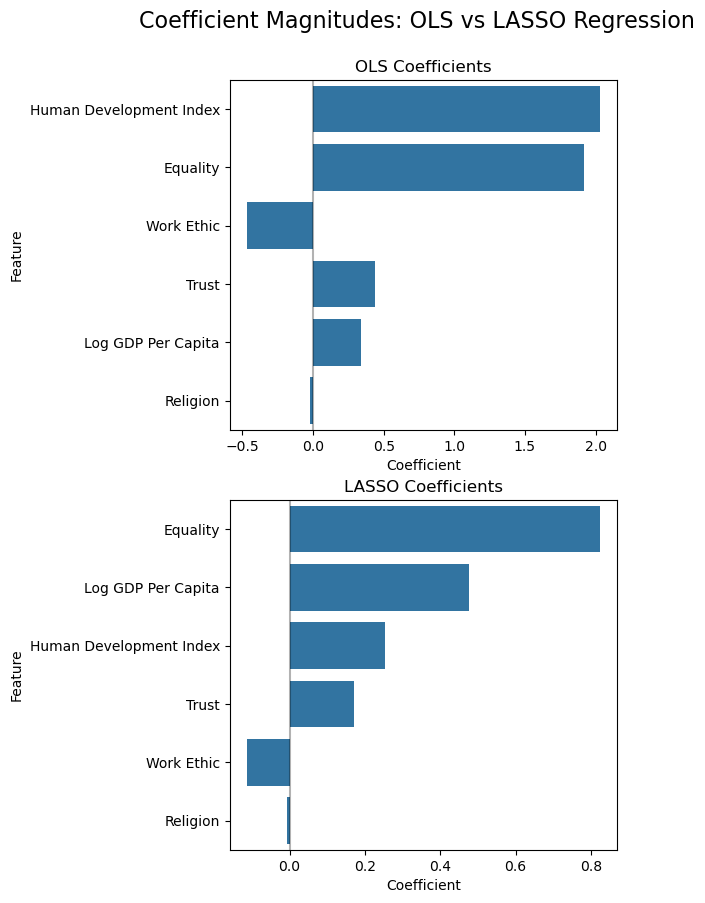

In [109]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
fig.suptitle('Coefficient Magnitudes: OLS vs LASSO Regression', fontsize=16, y=0.95)

axes = axes.flatten()

# create OLS plot
sns.barplot(data=ols_results_sorted[1:], y='Feature', x='Coefficient', ax=axes[0], orient='h')
axes[0].set_title(f'OLS Coefficients')
axes[0].axvline(0, color='black', alpha=0.3)

sns.barplot(data=lasso_results_sorted[1:11], y='Feature', x='Coefficient', ax=axes[1], orient='h')
axes[1].set_title(f'LASSO Coefficients')
axes[1].axvline(0, color='black', alpha=0.3)


From comparing the OLS and LASSO coefficients, we can see some interesting patterns. In the OLS model, the Human Development Index and equality show the strongest positive relationships with democracy scores, followed by smaller positive effects from trust and log GDP per capita, while work ethic shows a negative relationship. However, when we look at the LASSO results, which reduce less important features, equality emerges as clearly the strongest predictor, followed by log GDP per capita, while HDI's importance is notably reduced. This suggests that equality and economic development (measured by GDP per capita) are the most fundamental determinants of democracy.

Now, let's calculate the standard errors for the OLS model. This will help us understand whether we believe our coefficients are significantly different from zero given our normality assumption on the data. We do not calculate standard errors for the LASSO model since there is no consensus on a statistically valid way to calculate standard errors for LASSO in the literature. Any statistically valid method here requires stringent assumptions and a very large dataset (Zhao et. al, 2021). This is because of the lack of an analytical solution for standard errors due to our regularization term. Regardless, the feature selection that was done by our LASSO model is useful in helping us understand the most important predictors of a democratic nation. Now, we will compute both the analytic confidence intervals for the OLS model and the bootstrapped confidence intervals. We use both for the following reasons:

The analytic confidence intervals are typically used in statistical analyses and are based in statistical theory. However, they require the assumptions of normality of residuals (errors) and homoskedasticity of residuals apply. In the case that these assumptions are not met, the bootstrap confidence interval provides us a more robust interval of estimates and can also capture non-linearities and asymmetries in the sampling distribution of estimates.


Citation: Sen Zhao. Daniela Witten. Ali Shojaie. "In Defense of the Indefensible: A Very Naïve Approach to High-Dimensional Inference." Statist. Sci. 36 (4) 562 - 577, November 2021. https://doi.org/10.1214/20-STS815

In [110]:
"""
Get R-squared value of OLS model
"""

y_pred =  best_pipeline_ols.predict(X)

r2 = r2_score(y, y_pred)

print(f"R-squared value of OLS model: {r2:.3f}")

R-squared value of OLS model: 0.570


Our R-squared value tells us that about 56% of the variation in our democracy scores across countries is explained by our OLS regression model. This is a pretty high value which tells us that the development and values of a country appear to explain much of the variation in democracy scores across countries.

In [111]:
"""
Get analytic confidence intervals
"""
n, p = X.shape
residuals = y - y_pred

# estimate variance of the error term
s2 = np.sum(residuals ** 2) / (n - p - 1)

# calculate standard errors
X_design_ols = np.hstack([np.ones((n, 1)), X])  # add intercept
se = np.sqrt(s2 * np.diag(np.linalg.inv(X_design_ols.T @ X_design_ols)))

# calculate confidence intervals
z_crit = 1.96
ci_lower_analytic = ols_coef_full - z_crit * se
ci_upper_analytic = ols_coef_full + z_crit * se

# add to OLS results dataframe
ols_results['SE'] = se
ols_results['CI_Lower_Analytic'] = ci_lower_analytic
ols_results['CI_Upper_Analytic'] = ci_upper_analytic


In [112]:
def bootstrap(X, y, pipeline, n_bootstraps=1000):
    """
    Performs bootstrap resampling and returns coefficient estimates for each bootstrap sample.
    - returns an array of shape (n_bootstraps, n_features + 1) containing coefficient estimates for each bootstrap sample, including intercept
    """
    bootstrap_coefs = []
    
    for i in range(n_bootstraps):
        # generate bootstrap sample
        X_bootstrap, y_bootstrap = resample(X, y, random_state=i)
        
        # fit pipeline on bootstrap sample
        pipeline_boot = clone(pipeline)
        pipeline_boot.fit(X_bootstrap, y_bootstrap)
                
        # get coefficients. includes intercept.
        coef_boot = np.concatenate([[pipeline_boot.named_steps['regressor'].intercept_], pipeline_boot.named_steps['regressor'].coef_])
        
        bootstrap_coefs.append(coef_boot)
    
    return np.array(bootstrap_coefs)

In [113]:
"""
Get bootstrap confidence intervals
"""
# get bootstrapped coefficients
ols_coef_bootstrap = bootstrap(X, y, best_pipeline_ols)
bootstrap_distributions = [ols_coef_bootstrap[:, i] for i in range(ols_coef_bootstrap.shape[1])]

# calculate standard errors
se_boot = np.std(ols_coef_bootstrap, axis=0)

# calculate bootstrapped confidence intervals
ci_lower_boot = ols_coef_full - z_crit * se_boot
ci_upper_boot = ols_coef_full + z_crit * se_boot

# add to OLS results dataframe
ols_results['SE_Boot'] = se_boot
ols_results['CI_Lower_Boot'] = ci_lower_boot
ols_results['CI_Upper_Boot'] = ci_upper_boot
ols_results['Bootstrap'] = bootstrap_distributions

display(ols_results)

,Feature,Coefficient,SE,CI_Lower_Analytic,CI_Upper_Analytic,SE_Boot,CI_Lower_Boot,CI_Upper_Boot,Bootstrap
0,Intercept,-3.960031,1.585584,-7.067776,-0.852287,2.017434,-7.914202,-0.005861,"[-3.3527140489445832, -2.635444514811063, -2.6..."
1,Work Ethic,-0.465768,0.285245,-1.024847,0.093312,0.298081,-1.050006,0.118471,"[-1.0210574414666407, -0.5614620032747123, -0...."
2,Trust,0.441535,0.238651,-0.026221,0.909291,0.201226,0.047131,0.835938,"[0.4159637881467577, 0.17779185749174986, 0.33..."
3,Equality,1.916427,0.252937,1.420669,2.412184,0.226834,1.471832,2.361021,"[2.367278281398861, 1.9068884946677536, 2.2072..."
4,Religion,-0.025137,0.159568,-0.337890,0.287615,0.208712,-0.434212,0.383938,"[0.23423658156859575, -0.3223532879283085, 0.0..."
5,Log GDP Per Capita,0.341164,0.166447,0.014928,0.667400,0.221273,-0.092531,0.774859,"[-0.12157196850635756, 0.6764464520036564, -0...."
6,Human Development Index,2.027983,1.694424,-1.293088,5.349055,1.908544,-1.712762,5.768729,"[5.64544174882015, -1.5198457765197138, 4.7291..."


Here are visualizations of the distributions for the bootstrapped LASSO coefficients, along with the bootstrapped and analytic confidence intervals.

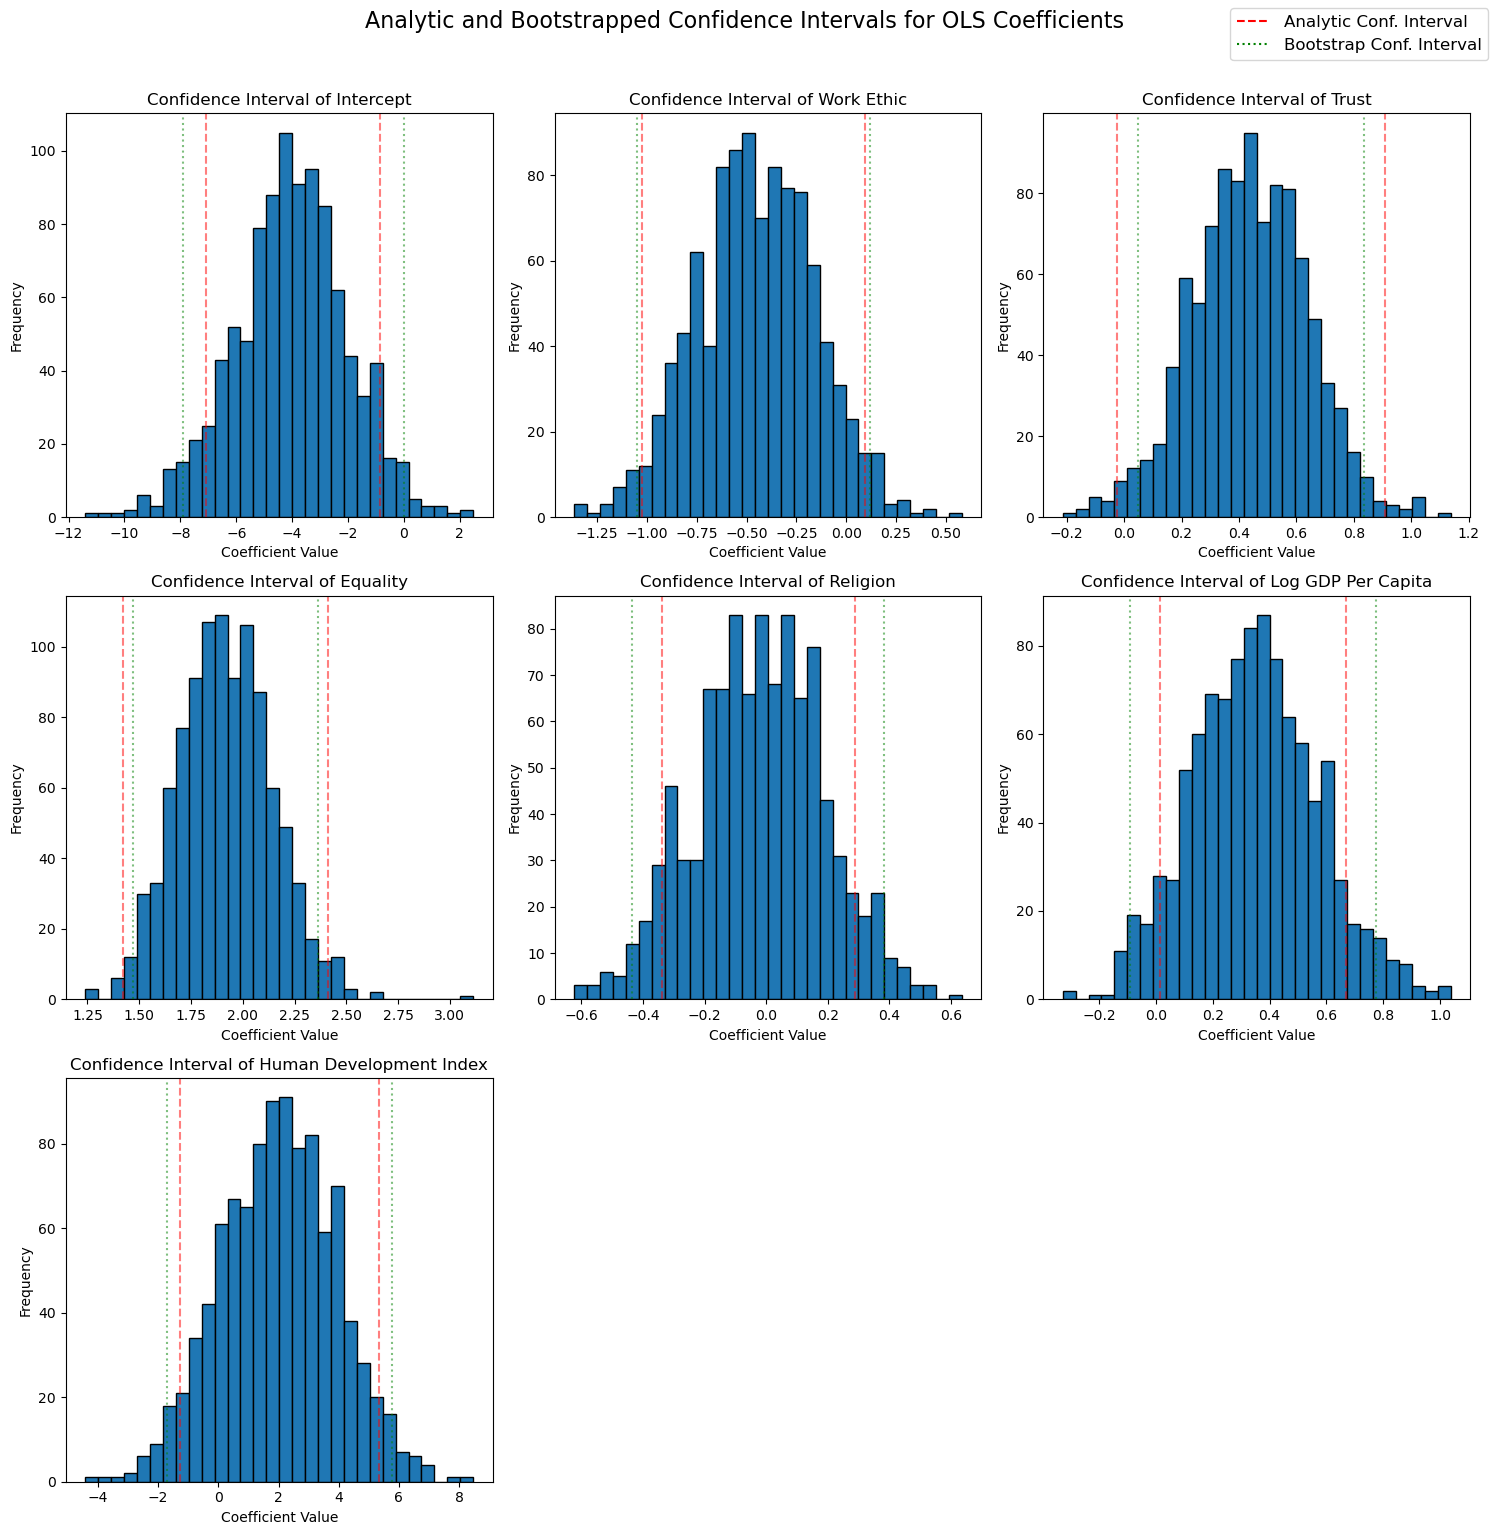

In [114]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Analytic and Bootstrapped Confidence Intervals for OLS Coefficients', fontsize=16, y=1.02)
axes = axes.flatten()

# create legend
legend_elements = [
    plt.Line2D([0], [0], color='r', linestyle='--', label='Analytic Conf. Interval'),
    plt.Line2D([0], [0], color='g', linestyle=':', label='Bootstrap Conf. Interval')
]

# plot histograms for each feature
for i, (idx, row) in enumerate(ols_results.iterrows()):
    feature = row['Feature']
    ci_lower_analytic = row['CI_Lower_Analytic']
    ci_upper_analytic = row['CI_Upper_Analytic']
    ci_lower_boot = row['CI_Lower_Boot']
    ci_upper_boot = row['CI_Upper_Boot']
    coef_dist = row["Bootstrap"]  
      
    # Create histogram
    axes[i].hist(coef_dist, bins=30, edgecolor='black')
    
    # Add vertical lines for confidence intervals
    axes[i].axvline(x=ci_lower_analytic, color='r', linestyle='--', alpha=0.5)
    axes[i].axvline(x=ci_upper_analytic, color='r', linestyle='--', alpha=0.5)
    axes[i].axvline(x=ci_lower_boot, color='g', linestyle=':', alpha=0.5)
    axes[i].axvline(x=ci_upper_boot, color='g', linestyle=':', alpha=0.5)
    
    # Add title and labels
    axes[i].set_title(f'Confidence Interval of {feature}')
    axes[i].set_xlabel('Coefficient Value')
    axes[i].set_ylabel('Frequency')

# Hide empty subplots
for i in range(len(lasso_results), len(axes)):
    axes[i].set_visible(False)

fig.legend(handles=legend_elements, loc='upper right', fontsize = 12)

plt.tight_layout()
plt.show()

Using the OLS model, we can now do proper inference to see which of the features are statistically significant. Based on both the bootstrapped and analytic confidence intervals, the "equality" metric is the only significant predictor of democracy, though log GDP per capita and Trust are both nearly significant. This is consistent with the analysis from the LASSO regression above, which selected equality as the strongest predictor. Intuitively, it makes sense that few metrics would be significant. That is because many of these indices are highly correlated, and so by including them all in a single regression, it dilutes the effect of each one by eliminating confounders and minimizing omitted variable bias.

Now, we will use statistical inference to check whether equality actually exhibits a quadratic relationship with democracy score. To do this, we will include an equality squared term in the OLS regression, and see whether it's statistically significant at the five percent level.

In [115]:

predictors_v2 = predictors + ['equality_squared']
X_v2 = df[predictors_v2]
ols_pipeline = Pipeline([
    ('regressor', LinearRegression())
])
ols_cv = cross_validate(
    ols_pipeline,
    X_v2, y,
    cv=10,
    scoring='neg_mean_squared_error',
    return_train_score=True
)
ols_pipeline.fit(X_v2, y)
coef_dict = dict(zip(predictors_v2, ols_pipeline.named_steps['regressor'].coef_))
for pred, coef in coef_dict.items():
    print(f"{pred}: {coef:.3f}")
X_with_const = sm.add_constant(X_v2)
model_eq_squared = sm.OLS(y, X_with_const)
results_eq_squared = model_eq_squared.fit()
print("\nEquality squared p-value:", results_eq_squared.pvalues['equality_squared'])

work_ethic: -0.359
trust: 0.309
equality: -0.313
religion: -0.032
log_gdp_per_capita: 0.325
hdi: 2.159
equality_squared: 0.403

Equality squared p-value: 0.21537380592086527


Note that the equality_squared coefficient is not stastistically significant. (4.03 minus 1.96 * 0.215 is less than zero --- barely!) This means that there is no statistically significant non-linear relationship between any of the variables and democracy score.

Next, we will see if equality is still significant when we include country fixed effects and wave fixed effects. This idea comes directly from milestone 3.

In [139]:
country_dummies = pd.get_dummies(df['country'], prefix='country', drop_first=True, dtype=int)
wave_dummies = pd.get_dummies(df['wave'], prefix='wave', drop_first=True, dtype=int)
X_full = pd.concat([
    X,
    country_dummies,
    wave_dummies
], axis=1)
ols_fe_pipeline = Pipeline(steps=[
   ('regressor', LinearRegression())
])
ols_fe_cv = cross_validate(
    ols_fe_pipeline,
    X_full, y,
    cv=10,
    scoring='neg_mean_squared_error',
    return_train_score=True
)
ols_fe_pipeline.fit(X_full, y)
best_model_fe = ols_fe_pipeline.named_steps['regressor']
best_pipeline_fe = ols_fe_pipeline
fe_coef_full = np.concatenate(([best_model_fe.intercept_], best_model_fe.coef_))
fe_results = pd.DataFrame({
    'Feature': ['Intercept'] + list(X_full.columns),  # Changed from predictors to all columns
    'Coefficient': fe_coef_full
})
y_pred_fe = best_pipeline_fe.predict(X_full)
n_fe, p_fe = X_full.shape
residuals_fe = y - y_pred_fe
s2_fe = np.sum(residuals_fe ** 2) / (n_fe - p_fe - 1)
X_design_fe = np.hstack([np.ones((n_fe, 1)), X_full])
se_fe = np.sqrt(s2_fe * np.diag(np.linalg.inv(X_design_fe.T @ X_design_fe)))
z_crit = 1.96 
ci_lower_fe = fe_coef_full - z_crit * se_fe
ci_upper_fe = fe_coef_full + z_crit * se_fe
fe_results['SE'] = se_fe
fe_results['CI_Lower'] = ci_lower_fe  
fe_results['CI_Upper'] = ci_upper_fe 

fe_results.head(6)

,Feature,Coefficient,SE,CI_Lower,CI_Upper
0,Intercept,0.778648,2.328921,-3.786036,5.343333
1,work_ethic,0.414707,0.161691,0.097793,0.731620
2,trust,-0.197786,0.169314,-0.529641,0.134069
3,equality,0.900858,0.279469,0.353099,1.448617
4,religion,-0.237916,0.164961,-0.561240,0.085408
5,log_gdp_per_capita,0.363906,0.170446,0.029831,0.697980


Interestingly, not only does equality remain significant, but work ethic and log gdp per capita become significant as well! When we include country and wave fixed effects, we're essentially looking at how changes in these variables WITHIN countries over time relate to changes in democracy scores, while controlling for any time-invariant country characteristics and any global trends that affect all countries in a given wave. This is different from our previous analysis that looked at differences BETWEEN countries.

We will now check whether our initial OLS regression assuptions are satisfied (which will help us make a decision on whether we think our analytical CIs are valid). First, we will see whether the residuals are approximately normally distributed.

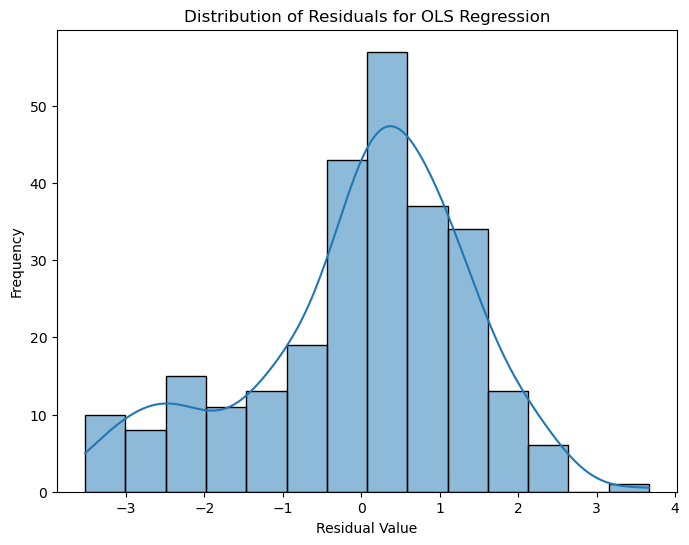

In [116]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals for OLS Regression')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

Next, we will check to see whether the residuals are homoskedastic.

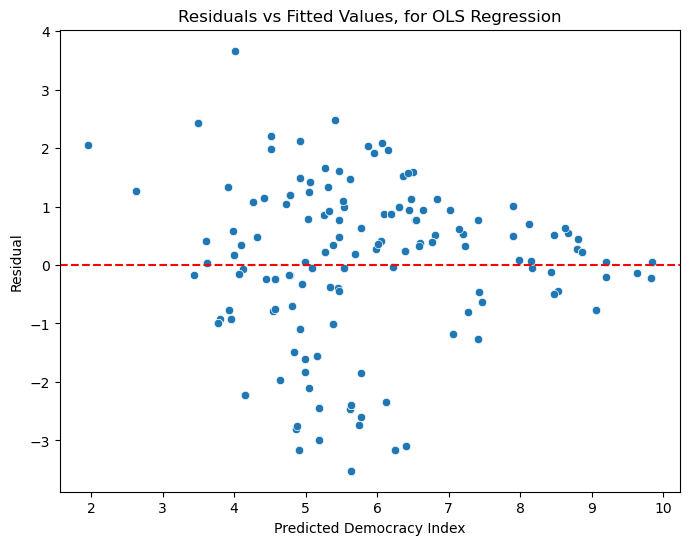

In [117]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values, for OLS Regression')
plt.xlabel('Predicted Democracy Index')
plt.ylabel('Residual')
plt.show()

As we can see from these two graphs above, normality and homoskedasticity of residuals appear to be violated. The violation of normality is less consequential given our larger sample size and the central limit theorem. Homoskedasticity appears to be significantly violated which does affect our calculation of our analytical standard errors which could lead to inaccurate tests and inference. Our bootstrapped CIs are more robust to this violation, however. Although the residual plot above may appear slightly nonlinear, our analysis above illustrates that there is no significant breaching of nonlinearity. In addition, with high $n$, the violation of homoskedasticity is less consequential on our inference. As we saw in our heatmaps from our EDA, there does appear to be some issues with multicollinearity as some predictors have moderately large correlation coefficients with each other (|r| > 0.5). This can be a potential issue as it means our coefficient predictions are less stable and our inference is less reliable. 

With all of this being said, we believe that our multiple OLS regression is a great baseline model, but we still feel that it would be valuable to do more modeling to make sure that our results are truly robust to these issues of multicollinearity and homoskedasticity. As such, we want to use a random forest regression model as our final model for variable selection. Even though we did not find any significant nonlinearities in our errors, the random forest is still robust to any of these issues of nonlinearity. This is because the splits of a decision tree create piecewise boundaries on there own. In addition, variable importance from permutation tests of a random forest model do not depend at all on any normality or homoskedasticity assumptions. 

Decision trees are also more robust to multicollinearity. Indeed, Genuer et. al (2010), a peer-reviewed paper cited over 3000 times, shows that when engaging in variable selection for interpretation purposes, the addition of highly-correlated variables to already-known important vriables only affected the magnitude -- NOT the order -- of variable importance for the random forest permutation importance statistics. They also show that the optimal way to engage in variable selection for interpretation purposes aligned with our method chosen in our proposal: Construct RF models with different hyperparameter values and choose the RF model with the lowest OOB error rate for interpretation and feature selection. 

There are, however, tradeoffs to the use of this final model. The RF model is less interpretable than a linear regression and pretty much only useful for feature selection given that our project is not concerned with prediction. We also are unable to engage in any meaningful inference using this model either. Thus, although the RF model is seen as our ``final model'' for the reasons detailed above, it is not our only model and we will still consider the multiple OLS regression in our discussion of the results.

Citation: Robin Genuer, Jean-Michel Poggi, Christine Tuleau-Malot. Variable selection using Random Forests. Pattern Recognition Letters, Elsevier, 2010, 31 (14), pp.2225-2236.



### Random Forest Regression Pipeline

Given our discussion above, we will now build a pipeline for our random forest regression model. 

A few things about how we set up preprocessing for pipeline:

- We do not need to engage in any feature preprocessing again. We do not need to standardize our variables because decision trees use _thresholds_ rather than _levels_, which means that different scales do not affect our overall fit or our ultimate feature importance values. 
- We do not need any specific polynomial or log transformation as decision trees can inherently capture non-linear relationships in the data because its splits create piecewise decision boundaries on its own.

The model selection process will be as follows:

- The hyperparameters that we need to tune are: 
    - We will use MSE as our splitting criteria. This is the main criteria used by most practioners and the only one we learned in class. 
    - Max_features: Sqrt or log2. Sqrt is the method that most long time practicioners use for random forests and log2 is another popular method so we will try both.
    - Number of trees: (1 to 250 with stepsize of 25): We need to figure out how many trees should be fit. Given that our dataset is not huge, we expect a fairly low number of trees need to be fit to best generalize to our data and after that there are diminishing returns. 
    - Complexity: We will tune max_depth, max_leaf_nodes, and min_impurity_decrease (also known as accuracy gain) as our separate measures for limiting complexity. Max_depth and max_leaf_nodes are both classic methods of controlling complexity and differ in how balanced the tree becomes while min_impurity_decrease is a frequently used method for controlling complexity in decision tree regression cases.
        - For now, we will iterate through max depth values between 1 and 25 with stepsize of 2, max leaf nodes values between 1 and 100 with stepsize of 5, and impurity decrease thresholds between 0 and 0.5 (0, 0.0001, 0.001, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5). These are subject to change as we work with the model and see results but are good starting points for testing complexity.
        - We will use only one of these complexity methods at a time rather than use multiple of these complexity reduction methods at once as this would be far too computationally complex and likely not that useful for our purposes of interpreting feature importance.
    
- To choose our hyperparameters, we will use out-of-bag error. We use this over cross validation since with cross validation there is a leakage of data (every validation has been seen in training by a few decision trees and there is thus some form of leakage). OOB prevents leakage and has a lower computation cost. 

Once we have chosen the best hyperparameters for our model, we can then engage in feature importance analysis. We can begin by looking at permutation importance which is more robust than built-in MDI importance as discussed in class (MDI usually focuses too much on variables with high cardinality or numerical variables). 

We also will experiment with LIME as a way to measure feature importance because it:
- Provide us with local explanations. In other words, it explains individual predictions by estimating the importance of each feature for a specific data point.
- It allows for greater interpretability -- we can look at why our model gave specific predictions. 
- Having both a global and a local variable importance measure will give us more information regarding the associations between countries' various beliefs and how democratic they are.

In [118]:
"""Function for tuning random forest model using OOB error"""

def tune_random_forest(X_train, y_train, params_grid, random_state, preprocessor=None):
    """
    Tune a Random Forest model using OOB error.
    - X_train: training data
    - y_train: training labels
    - params_grid: dictionary of hyperparameters to search over
    - random_state: random seed
    - preprocessor: preprocessor to use in pipeline
    """

    best_params = None
    best_oob_score = 0
    results = []

    # iterate through all possible hyperparameter combos 
    for param in ParameterGrid(params_grid):
        # set up pipeline
        if preprocessor:
            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', RandomForestRegressor(random_state=random_state, oob_score=True, **param))
            ])
        else:
            pipeline = Pipeline(steps=[
                ('classifier', RandomForestRegressor(random_state=random_state, oob_score=True, **param))
            ])

        # fit model
        pipeline.fit(X_train, y_train)

        # get OOB score
        oob_score = pipeline.named_steps['classifier'].oob_score_

        # save results
        results.append({
            'params': param,
            'oob_score': oob_score
        })

        # update best parameters
        if oob_score > best_oob_score:
            best_oob_score = oob_score
            best_params = param
            
    return {'best_params': best_params, 'best_oob_score': best_oob_score, 'results': results}
